In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime, date, timedelta
import requests
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from matplotlib.patches import Ellipse
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import plotly.express as px
from bs4 import BeautifulSoup
import numpy as np
warnings.filterwarnings('ignore')
# формат чисел
# pd.options.display.float_format ='{:,.3f}'.format

In [7]:
def get_current_inflation() -> np.float64:
    """
    Парсим сайт уровень-инфляции.рф
    В таблице находим строку с уровнем инфляции на последние "12 месяцев)"
    Из этой таблицы берем % инфляции
    """
    
    response = requests.get('https://уровень-инфляции.рф')
    soup = BeautifulSoup(response.text, 'lxml')
    text = soup.find('table').get_text()
    return np.float64(text[text.find('12 месяцев)') + 11:text.find('12 месяцев)') + 15])

def get_current_key_rate() -> np.float64:
    """
    Скачиваем таблицу с ключевыми ставками с сайта ЦБ РФ. Выбираем самую актуальную ставку
    """
    
    df = pd.read_html('https://www.cbr.ru/hd_base/KeyRate/')[0]
    tax_rate = pd.read_html('https://www.cbr.ru/hd_base/KeyRate/')[0].iloc[0]['Ставка']
    return tax_rate/100

# Постановка задачи

Определение доходности облигаций по данным ММВБ
Disclaimer: данное задание подготовлено исключительно для тренировки навыков
анализа данных, результаты выполнения задания не являются рекомендациями по
операциям с облигациями, автор задания не является инвестиционным
консультантом.
Имеются данные по облигациям, которые торгуются на ММВБ на текущую дату.
Требуется выполнить следующие действия с данными по облигациям на дату
формирования данных:
1. Оценить рынок рублевых облигаций по распределению купонной доходности,
предложить разделение на кластеры по купонной доходности.
Предложить графическое представление полученных групп/кластеров. (график)
2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по
купонам не более 20% купонного периода назад до текущей даты и облигациям
выпущенным в аналогичный период, рассчитать доходность последующих
купонов по отобранным облигациям с учетом разницы номинала и цены продажи,
а также с учетом налоговых отчислений на период год с текущей дата. (график
и/или таблица).
3. Допускается обоснованное изменение условий как по критериям оценки рынка,
так с учетом выбранной стратегии инвестирования.
Датасет с данными расположен по адресу:
https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.
%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&li
mit=unlimited&lang=ru
На усмотрение слушателя:
• можно скачать и загрузить в вашем скрипте файл csv (например,
pd.read_csv с указанием русской кодировки, релевантного знака
сепарирования и номера строки заголовков),
• загружать on-line:
s=requests.get(bond_url).content
pd.read_csv(io.StringIO(s.decode('УКАЗАТЬ КОДИРОВКУ')), sep='СЕПАПРАТОР', header=№ СТРОКИ
ЗАГОЛОВКОВ)
Могут быть использованы следующие поля (а также все остальные) в любых
комбинациях:

'SECID' - Код ценной бумаги,
'SHORTNAME' - Краткое наименование,
'NAME' Полное наименование,
'FACEVALUE' - Номинальная стоимость,
FACEUNIT' - валюта,
'DURATION' - дюрация,
'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов,
'HIGH_RISK' - признак уровня риска,
'COUPONFREQUENCY' – число купонов в год,
'COUPONDATE' - Дата выплаты купона,
'COUPONPERCENT' - Ставка купона, %,
'COUPONVALUE' - Сумма купона, в валюте номинала, 
'OFFERDATE' - Дата оферты,
'EMITENTNAME' – наименование эмитента,
'INN' – ИНН эмитента,
'PRICE' – текущий % от FACEVALUE,
'PRICE_RUB' - котировка,

Пояснения:
1. Для получения текущей даты можно использовать метод datetime.date.today();

2. Период расчета доходности рекомендуется выбирать 365 дней с текущей даты;

3. Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ;

4. В общем случае процентный доход при ставке НДФЛ 13% будет
Profit =(Цена_Номинальная – Цена_покупки – НКД + 0.87*Купонный_доход_руб*X_лет)*100% /(Цена_покупки + НКД) (комиссией брокера
пренебрегаем)

5. Период расчета НКД: df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется
выбирать меньше или равный 0.2.
Если удовлетворяет условию, полученная величина умножается
на COUPONPERCENT/COUPONFREQUENCY.

6. Датасет содержит данные, которые нужно преобразовывать в форматы python, а также
пустые и искаженные данные, с которыми нужно что-то решить.

# Описание данных

Текстовые:
1. **SECID** - Код ценной бумаги. non-null
2. **SHORTNAME**- Краткое наименование. non-null
3. '**NAME**' - Полное наименование. non-null
4. '**ISIN**' - ISIN код. non-null
5. '**PRIMARY_BOARD_TITLE**' - Режим торгов. non-null
6. '**REGNUMBER**' - номер выпуска. 
7. '**EMITENTNAME**' – наименование эмитента. 
8. '**INN**' – ИНН эмитента. 

Бинарные:

9. 'IS_COLLATERAL' - . non-null
10. '**IS_EXTERNAL**' - внешний. non-null
11. '**EVENINGSESSION**' - Вечерняя сессия. non-null
12. **IS_QUALIFIED_INVESTORS** - признак продукта для 
квалифицированных инвесторов. non-null
13. '**HIGH_RISK**' - признак уровня риска. non-null

Категориальные:

14. '**LISTLEVEL**' - Уровень листинга
15. '**TYPENAME**' - Вид/категория ценной бумаги. non-null
16. '**FACEUNIT**' - валюта. non-null
17. '**PRIMARY_BOARDID**' - Идентификатор режима торгов. non-null
18. '**SECSUBTYPE**' - Подтип облигации. очень много null
19. 'IS_RII' - . очень много null

Временные:

20. '**MATDATE**' - Дата погашения
21. '**ISSUEDATE**' - Дата начала торгов
22. '**COUPONDATE**' - Дата выплаты купона
23. '**ISSUEDATE.1**' - Дата начала торгов
24. '**STARTDATEMOEX**' - Дата начала торгов на Московской Бирже
25. '**OFFERDATE**' - Дата оферты

Вещественные:

26. '**FACEVALUE**' - Номинальная стоимость. non-null
27. '**INITIALFACEVALUE**' - Номинальная стоимость. non-null
28. '**DAYSTOREDEMPTION**' - Дней до погашения
29. '**LOTSIZE**' - Размер лота, ц.б. non-null
30. '**PRICE**' – текущий % от FACEVALUE
31. '**PRICE_RUB**' - котировка
32. '**DURATION**' - дюрация
33. '**COUPONFREQUENCY**' – число купонов в год
34. '**YIELDATWAP**' - Доходность по средневзвешенной цене. очень много null
35. '**COUPONPERCENT**' - Ставка купона
36. '**COUPONVALUE**' - Сумма купона
37. '**COUPONDAYSPASSED**' - прошло дней с выплаты купона
38. '**COUPONDAYSREMAIN**' - дней до выплаты купона
39. '**COUPONLENGTH**' - периодичность выплаты купона
40. '**ISSUESIZE**' - Объем выпуска

Прочие:

41. 'RTL1'
42. 'RTH1'
43. 'RTL2'
44. 'RTH2'
45. 'RTL3'
46. 'RTH3'
47. 'DISCOUNT1' non-null
48. 'LIMIT1'
49. 'DISCOUNT2'
50. 'LIMIT2'
51. 'DISCOUNT3'
52. 'DISCOUNTL0'
53. 'DISCOUNTH0'

# 1.Загрузка и предобработка данных от 08.10.2021

In [41]:
#https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru
# !wget 'https://drive.google.com/uc?export=download&id=1mNBum8AiQMHK6zC-2-Y5LNT8mJLuCdit' -O './rates.csv'

DATASET_DATE = pd.to_datetime('2020.10.22')
KEY_RATE = get_current_key_rate()
INFLATION_RATE = get_current_inflation()
INVEST_PERIOD = 365
TAX_RATE = 0.13

In [43]:
df = pd.read_csv('rates.csv', sep=';', header=1, encoding='cp1251', dtype={'INN': 'string', 'LISTLEVEL': 'object'})
df.sample(10)

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTH2,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0
557,RU000A0ZYFG7,Солид-Лизинг обКП04,Солид-Лизинг обКП04,Коммерческая облигация,RU000A0ZYFG7,4CDE-04-00330-R-001P,NaN,"1000,0",RUB,45000000.0,...,NaN,NaN,NaN,"100,0",NaN,NaN,NaN,NaN,NaN,NaN
2410,XS1120709826,KAZ-44,REPUBLIC OF KAZAKHSTAN 4.875,Облигации государств,XS1120709826,NaN,NaN,"1000,0",USD,1000000.0,...,"172732,32",NaN,"172732,32","100,0",NaN,NaN,NaN,NaN,NaN,NaN
113,RU000A0JU773,ВТБ БО-43,Банк ВТБ (ПАО) БО-43,Биржевые облигации,RU000A0JU773,4B024301000B,1,"1000,0",RUB,20000000.0,...,"1242,31","715,57","1272,13","22,0",393241.0,"25,0",1966204.0,"28,0","7,00","7,00"
1223,RU000A101CG5,ФридФин1П1,ИК Фридом Финанс П01-01,Биржевые облигации,RU000A101CG5,4B02-01-00430-R-001P,3,"1000,0",USD,30043.0,...,"151774,56",NaN,"151774,56","100,0",NaN,NaN,NaN,NaN,NaN,NaN
2058,RU000A103745,БК обК02,БК обК02,Коммерческая облигация,RU000A103745,4CDE-02-00500-R,NaN,"10000,0",RUB,16000000.0,...,NaN,NaN,NaN,"100,0",NaN,NaN,NaN,NaN,NaN,NaN
351,RU000A0JWVC1,ТрнфБО1P4,Транснефть ПАО БО-001P-04,Биржевые облигации,RU000A0JWVC1,4B02-04-00206-A-001P,2,"1000,0",RUB,15000000.0,...,"1141,58","866,38","1172,16","9,0",300000.0,"12,0",1500000.0,"15,0","10,00","10,00"
2381,XS0743596040,SB-22,SB CAPITAL S.A. 6.125 07/02/22,Корпоративные еврооблигации,XS0743596040,NaN,3,"1000,0",USD,1500000.0,...,"83274,57","59378,39","85446,95","12,0",30000.0,"15,0",150000.0,"18,0","26,00","26,00"
354,RU000A0JWWM8,ТрансФ1P01,ТрансФин-М ПАО 001P-01,Биржевые облигации,RU000A0JWWM8,4B02-01-50156-A-001P,2,"1000,0",RUB,650002.0,...,"2044,18",NaN,"2044,18","100,0",NaN,NaN,NaN,NaN,"10,00","10,00"
432,RU000A0JXPU3,Калаш БП1,Концерн Калашников БО-П01,Биржевые облигации,RU000A0JXPU3,4B02-01-57320-D-001P,2,"1000,0",RUB,3000000.0,...,"2009,4",NaN,"2009,4","100,0",NaN,NaN,NaN,NaN,"10,00","10,00"
2687,XS2381361646,BCS09/24-3,BCS SP Plc Series 208,Корпоративные еврооблигации,XS2381361646,NaN,3,"100000,0",RUB,800.0,...,"200000,0",NaN,"200000,0","100,0",NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
CATEGORICAL_COLS = ['TYPENAME', 'LISTLEVEL', 'FACEUNIT', 'PRIMARY_BOARDID', 'SECSUBTYPE', 'IS_RII']

BINARY_COLS = ['IS_COLLATERAL', 'IS_EXTERNAL', 'IS_QUALIFIED_INVESTORS', 'EVENINGSESSION', 'HIGH_RISK']

DATE_COLS = ['MATDATE', 'ISSUEDATE', 'COUPONDATE', 'ISSUEDATE.1', 'STARTDATEMOEX', 'OFFERDATE']

COLS_CONVERT_TO_FLOAT = ['FACEVALUE', 'COUPONPERCENT', 'COUPONVALUE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'DISCOUNT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0']

In [45]:
# изменяем формат временных колонок
for col in DATE_COLS:
    df[col] = pd.to_datetime(df[col])

# изменяем формат численных колонок
for col in COLS_CONVERT_TO_FLOAT:
    df[col] = df[col].str.replace(',', '.').astype('float64')


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2696 entries, 0 to 2695
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SECID                   2696 non-null   object        
 1   SHORTNAME               2696 non-null   object        
 2   NAME                    2696 non-null   object        
 3   TYPENAME                2696 non-null   object        
 4   ISIN                    2696 non-null   object        
 5   REGNUMBER               2305 non-null   object        
 6   LISTLEVEL               2437 non-null   object        
 7   FACEVALUE               2696 non-null   float64       
 8   FACEUNIT                2696 non-null   object        
 9   ISSUESIZE               2676 non-null   float64       
 10  IS_COLLATERAL           2696 non-null   int64         
 11  IS_EXTERNAL             2696 non-null   int64         
 12  PRIMARY_BOARDID         2696 non-null   object  

In [13]:
df.describe()

,FACEVALUE,ISSUESIZE,IS_COLLATERAL,IS_EXTERNAL,EVENINGSESSION,DURATION,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,COUPONPERCENT,...,RTH2,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0
count,2.696000e+03,2.676000e+03,2696.000000,2696.000000,2696.000000,1867.000000,2696.000000,2696.000000,2321.000000,2587.000000,...,2.510000e+03,8.230000e+02,2.510000e+03,2696.000000,8.780000e+02,878.000000,8.780000e+02,878.000000,1007.000000,1007.000000
mean,2.027029e+06,3.226170e+08,0.140950,0.155786,0.130193,850.220675,0.184718,0.062315,3.051271,6.277270,...,4.302928e+05,2.595545e+05,4.334945e+05,72.665616,3.350430e+05,18.977790,1.674611e+06,26.070046,21.002979,20.317776
std,9.636516e+07,4.167629e+09,0.348034,0.362720,0.336578,685.591437,0.388141,0.241771,2.296821,4.275894,...,3.721487e+06,1.690996e+06,3.732030e+06,39.719316,8.351049e+05,9.873361,4.175706e+06,21.172903,27.625315,27.684539
min,1.950000e-01,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.010000,...,1.216000e+01,1.406000e+01,1.216000e+01,3.000000,1.700000e+01,4.000000,8.500000e+01,5.000000,4.000000,4.000000
25%,1.000000e+03,3.232918e+05,0.000000,0.000000,0.000000,364.500000,0.000000,0.000000,2.000000,1.587500,...,1.201608e+03,7.788700e+02,1.246697e+03,20.000000,1.000000e+05,12.000000,5.000000e+05,15.000000,10.000000,10.000000
50%,1.000000e+03,2.459051e+06,0.000000,0.000000,0.000000,728.000000,0.000000,0.000000,2.000000,7.000000,...,1.963200e+03,8.320600e+02,1.972790e+03,100.000000,2.000000e+05,17.000000,1.000000e+06,20.000000,10.000000,10.000000
75%,1.000000e+03,1.000000e+07,0.000000,0.000000,0.000000,1132.000000,0.000000,0.000000,4.000000,8.900000,...,2.092195e+03,9.141500e+02,2.095500e+03,100.000000,3.000000e+05,21.000000,1.500000e+06,26.000000,15.000000,10.000000
max,5.000000e+09,9.649987e+10,1.000000,1.000000,1.000000,5639.000000,1.000000,1.000000,12.000000,36.000000,...,1.335879e+08,1.571652e+07,1.335879e+08,100.000000,1.200000e+07,62.000000,6.000000e+07,100.000000,100.000000,100.000000


In [14]:
df.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                  391
LISTLEVEL                  259
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   20
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     48
IS_RII                    2678
ISSUEDATE                  145
EVENINGSESSION               0
DURATION                   829
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            375
YIELDATWAP                1443
COUPONDATE                  13
COUPONPERCENT              109
COUPONVALUE                110
COUPONDAYSPASSED            24
COUPONDAYSREMAIN            24
COUPONLENGTH                13
ISSUEDATE.1                145
INITIALFACEVALUE             0
SECSUBTYPE                2561
STARTDAT

# 2.Кластеризация

Попробуем сделать кластеризацию по бинарным, категориальным признакам + 'PRICE', 'COUPONPERCENT'

### 2.1 Кластеризация всех облигаций

Создадим временный датафрейм для кластеризации. Преобразуем категориальные признаки через get_dummies

In [15]:
clustering_df = df.copy()
clustering_df = pd.get_dummies(clustering_df[CATEGORICAL_COLS + BINARY_COLS + ['PRICE', 'COUPONPERCENT']], columns=CATEGORICAL_COLS).dropna()

Отмасштабируем признаки

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

Выберем оптимальное количество кластеров методом локтя по атрибуту inertia_

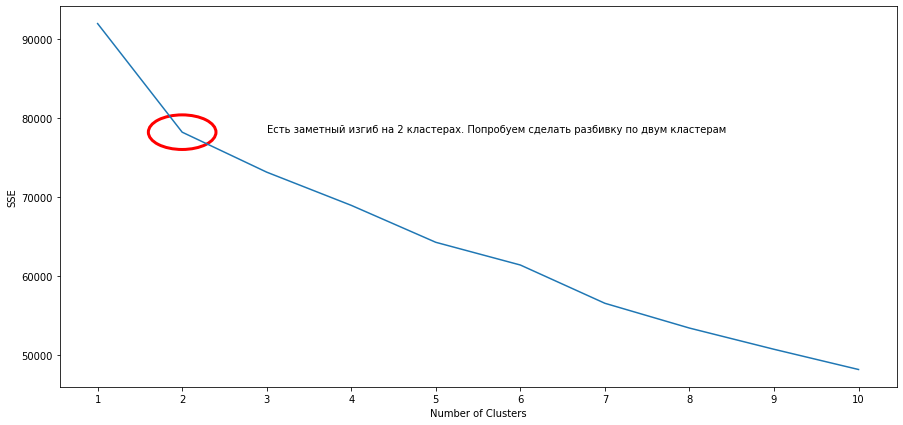

In [17]:
sse = []
kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 999}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(15,7))
ellipse = Ellipse((2, sse[1]), 
                  height=(max(sse) - min(sse)) / len(sse), 
                  width=0.8,
                  edgecolor='r',
                  fill=False,
                  linewidth=3)

ax.text(x=3, y=sse[1], s='Есть заметный изгиб на 2 кластерах. Попробуем сделать разбивку по двум кластерам')
ax.plot(range(1, 11), sse)
ax.add_patch(ellipse)
ax.set_xticks(range(1, 11))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

plt.show()

Обучаем модель на 2 кластера. Получаем разбиение

In [18]:
kmeans = KMeans(init="random",
                n_clusters=2,
                n_init=10,
                max_iter=300,
                random_state=999)

kmeans.fit(scaled_features)
clustering_df['Cluster'] = kmeans.labels_
clustering_df.Cluster.value_counts()

0    2104
1     315
Name: Cluster, dtype: int64

Посмотрим на описание 0 и 1 класса

In [19]:
clustering_df[clustering_df.Cluster==0].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Еврооблигации МинФина,TYPENAME_Коммерческая облигация,...,PRIMARY_BOARDID_TQOB,PRIMARY_BOARDID_TQOD,PRIMARY_BOARDID_TQOE,PRIMARY_BOARDID_TQRD,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Структурные облигации,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.0,2104.0,...,2104.000000,2104.0,2104.0,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.0
mean,0.131179,0.008555,0.086027,0.033270,0.077947,98.096661,6.086240,0.766635,0.0,0.0,...,0.023289,0.0,0.0,0.018061,0.025665,0.002852,0.017110,0.001426,0.007129,0.0
std,0.337676,0.092119,0.280470,0.179383,0.268152,13.878069,4.208638,0.423073,0.0,0.0,...,0.150856,0.0,0.0,0.133203,0.158173,0.053338,0.129713,0.037743,0.084154,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.010000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,96.517500,0.946000,1.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,99.600000,7.050000,1.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,100.500000,8.852500,1.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,198.210000,16.310000,1.000000,0.0,0.0,...,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [20]:
clustering_df[clustering_df.Cluster==1].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Еврооблигации МинФина,TYPENAME_Коммерческая облигация,...,PRIMARY_BOARDID_TQOB,PRIMARY_BOARDID_TQOD,PRIMARY_BOARDID_TQOE,PRIMARY_BOARDID_TQRD,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Структурные облигации,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.000000,315.0,...,315.0,315.000000,315.000000,315.0,315.0,315.0,315.000000,315.0,315.0,315.0
mean,0.298413,0.993651,0.650794,0.638095,0.003175,102.571238,5.925873,0.025397,0.047619,0.0,...,0.0,0.530159,0.082540,0.0,0.0,0.0,0.085714,0.0,0.0,1.0
std,0.458290,0.079555,0.477478,0.481316,0.056344,10.520217,3.413744,0.157577,0.213298,0.0,...,0.0,0.499884,0.275623,0.0,0.0,0.0,0.280387,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,47.090000,0.010000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0
25%,0.000000,1.000000,0.000000,0.000000,0.000000,99.485000,3.975000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0
50%,0.000000,1.000000,1.000000,1.000000,0.000000,101.850000,5.350000,0.000000,0.000000,0.0,...,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0
75%,1.000000,1.000000,1.000000,1.000000,0.000000,105.435000,7.500000,0.000000,0.000000,0.0,...,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,164.250000,36.000000,1.000000,1.000000,0.0,...,0.0,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,1.0


##### Различие между кластерами

Получилось неплохо разбить облигации на 2 класса с ярковыраженными отличиями.
Можно обобщить кластеры следующим образом:

**0 кластер** - внешние облигации в иностранной валюте для квалифицированных инвесторов

**1 кластер** - обычные рублевые облигации для неквалифицированных инвесторов

Различие в признаках:

**IS_EXTERNAL**:

0 кластер - 99%

1 кластер - 1%

**IS_QUALIFIED_INVESTORS**:

0 кластер - 64%

1 кластер - 8%

**EVENINGSESSION**

0 кластер - 67%

1 кластер - 3%

**TYPENAME_Биржевые облигации**:

0 кластер - 3%

1 кластер - 77%

**TYPENAME_Корпоративные еврооблигации**

0 кластер - 82%

1 кластер - 1%

**Инвалюта**:

0 кластер - 90%

1 кластер - 1%

**boardid**:

0 кластер - 56% на TQOD, 24% на RPMO

1 кластер - 90% на TQCB



##### Нарисуем кластеры
Попробуем снизить размерность исходного датафрейма до 2

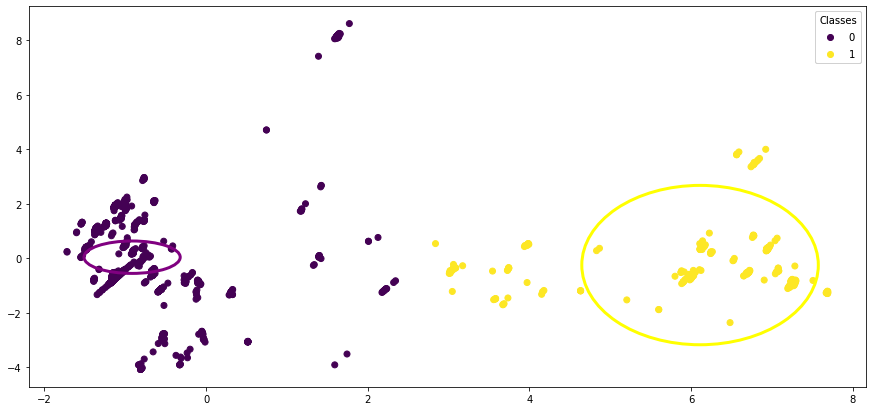

In [21]:
# Снижаем размерность до 2
pca = PCA(n_components=2)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)
ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std() * 2, 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)

plt.show()

In [17]:
# планирую сделать графики в plotly
# fig = px.scatter(x=X[:, 0], y=X[:, 1], color=kmeans.labels_, width=800, height=600)
# fig.show(renderer="colab")

Попробуем снизить размерность исходного датафрейма до 1 и добавить на ось ординат процентную ставку по купону

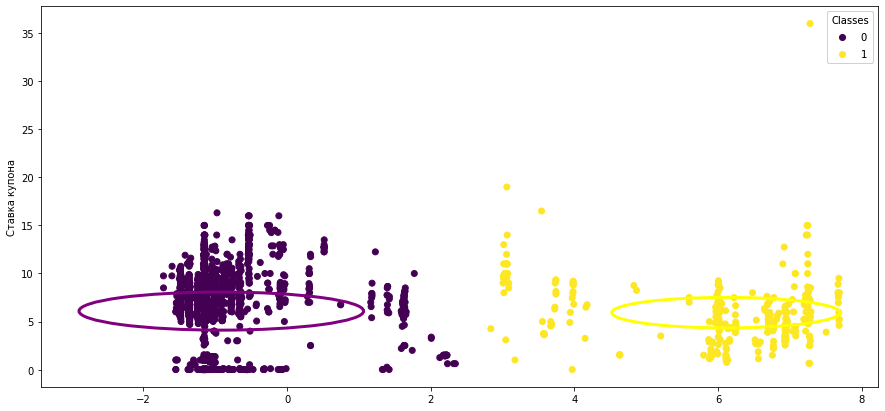

In [22]:
# Снижаю размерность до 1
pca = PCA(n_components=1)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, np.array(clustering_df.COUPONPERCENT).reshape(len(X), 1), kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)

ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X, clustering_df.COUPONPERCENT, c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.set_ylabel('Ставка купона')
plt.show()

### 2.2 Кластеризация низкорисковых рублевых облигаций

Оставим в датафрейме только рублевые безрисковые облигации. Удалим облигации, у которых нет цены

In [23]:
clustering_df = df.copy()
clustering_df = clustering_df[clustering_df.FACEUNIT == 'RUB']
clustering_df = clustering_df[clustering_df.IS_QUALIFIED_INVESTORS == 0]
clustering_df = clustering_df[clustering_df.HIGH_RISK == 0]
clustering_df = clustering_df[clustering_df.PRICE_RUB.notna()]

Преобразуем категориальные признаки через get_dummies

In [24]:
clustering_df = pd.get_dummies(clustering_df[CATEGORICAL_COLS + BINARY_COLS + ['PRICE', 'COUPONPERCENT']], columns=CATEGORICAL_COLS).dropna()

Отмасштабируем признаки

In [25]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

Выберем оптимальное количество кластеров методом локтя по атрибуту inertia_

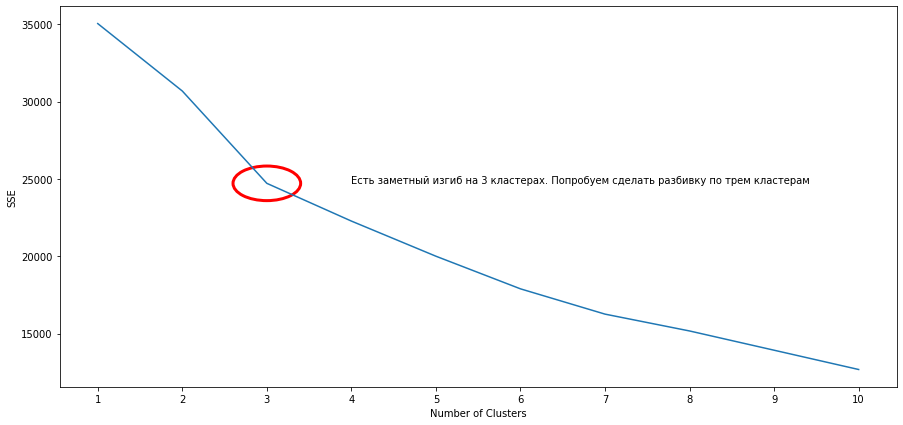

In [26]:
sse = []
kmeans_kwargs = {"init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 0}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(15,7))
ellipse = Ellipse((3, sse[2]), 
                  height=(max(sse) - min(sse)) / len(sse), 
                  width=0.8,
                  edgecolor='r',
                  fill=False,
                  linewidth=3)

ax.plot(range(1, 11), sse)
ax.add_patch(ellipse)
ax.set_xticks(range(1, 11))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")
ax.text(x=4, y=sse[2], s='Есть заметный изгиб на 3 кластерах. Попробуем сделать разбивку по трем кластерам')

plt.show()

Обучаем модель на 3 кластера. Получаем разбиение

In [27]:
kmeans = KMeans(init="random",
                n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=0)

kmeans.fit(scaled_features)
clustering_df['Cluster'] = kmeans.labels_
clustering_df.Cluster.value_counts()

1    918
0    785
2     49
Name: Cluster, dtype: int64

Посмотрим на описание классов

In [28]:
clustering_df[clustering_df.Cluster==0].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,...,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,785.000000,785.0,785.0,785.000000,785.0,785.000000,785.000000,785.000000,785.000000,785.000000,...,785.0,785.0,785.0,785.0,785.0,785.000000,785.0,785.0,785.000000,785.0
mean,0.044586,0.0,0.0,0.014013,0.0,98.917924,4.148429,0.973248,0.014013,0.012739,...,0.0,1.0,1.0,1.0,0.0,0.002548,0.0,0.0,0.014013,0.0
std,0.206525,0.0,0.0,0.117618,0.0,12.408657,4.597139,0.161459,0.117618,0.112217,...,0.0,0.0,0.0,0.0,0.0,0.050443,0.0,0.0,0.117618,0.0
min,0.000000,0.0,0.0,0.000000,0.0,31.590000,0.010000,0.000000,0.000000,0.000000,...,0.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0
25%,0.000000,0.0,0.0,0.000000,0.0,93.620000,0.010000,1.000000,0.000000,0.000000,...,0.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0
50%,0.000000,0.0,0.0,0.000000,0.0,99.270000,1.203000,1.000000,0.000000,0.000000,...,0.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0
75%,0.000000,0.0,0.0,0.000000,0.0,101.010000,8.000000,1.000000,0.000000,0.000000,...,0.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0
max,1.000000,0.0,0.0,1.000000,0.0,172.870000,15.000000,1.000000,1.000000,1.000000,...,0.0,1.0,1.0,1.0,0.0,1.000000,0.0,0.0,1.000000,0.0


In [29]:
clustering_df[clustering_df.Cluster==1].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,...,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,918.000000,918.0,918.0,918.000000,918.0,918.000000,918.000000,918.000000,918.000000,918.000000,...,918.000000,918.000000,918.0,918.0,918.0,918.000000,918.000000,918.000000,918.000000,918.0
mean,0.208061,0.0,0.0,0.013072,0.0,99.697793,7.708869,0.642702,0.013072,0.209150,...,0.356209,0.103486,1.0,1.0,0.0,0.055556,0.017429,0.003268,0.004357,1.0
std,0.406142,0.0,0.0,0.113645,0.0,7.322990,1.853806,0.479465,0.113645,0.406924,...,0.479139,0.304758,0.0,0.0,0.0,0.229186,0.130935,0.057104,0.065902,0.0
min,0.000000,0.0,0.0,0.000000,0.0,13.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.0,0.0,0.000000,0.0,97.900000,6.650000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.0,0.0,0.000000,0.0,99.605000,7.700000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
75%,0.000000,0.0,0.0,0.000000,0.0,100.287500,8.750000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,0.0,0.0,1.000000,0.0,198.210000,16.310000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.0,1.0,0.0,1.000000,1.000000,1.000000,1.000000,1.0


In [30]:
clustering_df[clustering_df.Cluster==2].describe()

,IS_COLLATERAL,IS_EXTERNAL,IS_QUALIFIED_INVESTORS,EVENINGSESSION,HIGH_RISK,PRICE,COUPONPERCENT,TYPENAME_Биржевые облигации,TYPENAME_Корпоративные еврооблигации,TYPENAME_Корпоративные облигации,...,LISTLEVEL_2,LISTLEVEL_3,FACEUNIT_RUB,PRIMARY_BOARDID_TQCB,PRIMARY_BOARDID_TQOB,SECSUBTYPE_Облигации с ипотечным покрытием,SECSUBTYPE_Субординированные облигации,IS_RII_P,IS_RII_R,Cluster
count,49.0,49.0,49.0,49.000000,49.0,49.000000,49.000000,49.0,49.0,49.0,...,49.0,49.000000,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
mean,1.0,0.0,0.0,0.959184,0.0,97.401429,6.357612,0.0,0.0,0.0,...,0.0,0.040816,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
std,0.0,0.0,0.0,0.199915,0.0,13.894979,1.772924,0.0,0.0,0.0,...,0.0,0.199915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,0.0,0.0,0.000000,0.0,20.180000,0.250000,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
25%,1.0,0.0,0.0,1.000000,0.0,95.660000,5.930000,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
50%,1.0,0.0,0.0,1.000000,0.0,98.960000,6.900000,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
75%,1.0,0.0,0.0,1.000000,0.0,100.070000,7.250000,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
max,1.0,0.0,0.0,1.000000,0.0,145.920000,10.000000,0.0,0.0,0.0,...,0.0,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


##### Различие между кластерами

Можно обобщить описание у 3 кластеров:

0 кластер - ОФЗ

1 кластер - биржевые облигации 3 уровня листинга с невысокой ставкой купона

2 кластер - биржевые облигации 1 и 2 уровней листинга с высокой ставкой купона

**COUPONPERCENT**:

0 кластер - 6.42%

1 кластер - 4.62%

2 кластер - 7.57%

**TYPENAME**:

0 кластер - 64% ОФЗ

1 кластер - 88% Биржевые облигации

2 кластер - 73% Биржевые облигации

**LISTLEVEL**:

0 кластер - 100% 1 и 3 уровень

1 кластер - 100% 3 уровень

2 кластер - 100% 1 и 2 уровень


##### Нарисуем кластеры

Попробуем снизить размерность исходного датафрейма до 2

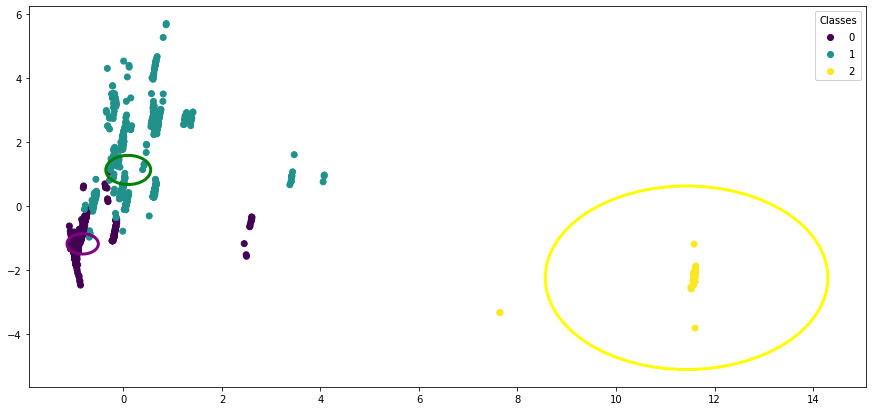

In [31]:
# Снижаем размерность до 2
pca = PCA(n_components=2)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)
ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='green',
                  fill=False,
                  linewidth=3)
ellipse3 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 2, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 2, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 2, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

plt.show()


Попробуем снизить размерность исходного датафрейма до 1 и добавить на ось ординат процетную ставку по купону

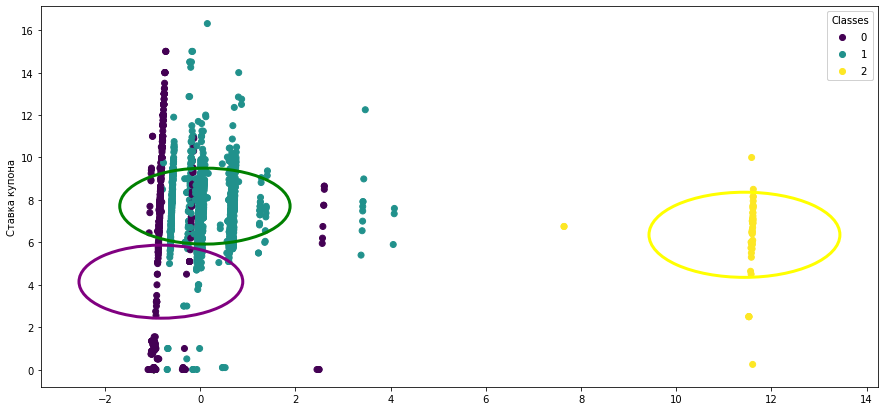

In [32]:
# Снижаем размерность до 1
pca = PCA(n_components=1)
pca.fit(scaled_features)
X = pca.transform(scaled_features)

# Соединяем полученную матрицу с номерами кластеров
array = np.concatenate((X, np.array(clustering_df.COUPONPERCENT).reshape(len(clustering_df.COUPONPERCENT), 1), kmeans.labels_.reshape(len(kmeans.labels_), 1)), axis=1)

# рисуем элипсы средних значений кластеров
ellipse1 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 0, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 0, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 0, array))).std(),
                  edgecolor='purple',
                  fill=False,
                  linewidth=3)
ellipse2 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 1, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 1, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 1, array))).std(),
                  edgecolor='green',
                  fill=False,
                  linewidth=3)
ellipse3 = Ellipse(xy=(np.array(list(filter(lambda x: x[2] == 2, array))).mean(axis=0)[0:2]), 
                  height=np.array(list(filter(lambda x: x[2] == 2, array))).std(), 
                  width=np.array(list(filter(lambda x: x[2] == 2, array))).std(),
                  edgecolor='yellow',
                  fill=False,
                  linewidth=3)

fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(X, clustering_df.COUPONPERCENT, c=kmeans.labels_)
legend = ax.legend(*scatter.legend_elements(),loc="best", title="Classes")
ax.add_artist(legend)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

ax.set_ylabel('Ставка купона')
plt.show()

# 3.Расчет доходности

Оставляем в исходном датафрейме только те облигации, по которым была произведена кластеризация

In [122]:
df = pd.read_csv('rates.csv', sep=';', header=1, encoding='cp1251', dtype={'INN': 'string', 'LISTLEVEL': 'object'})
CATEGORICAL_COLS = ['TYPENAME', 'LISTLEVEL', 'FACEUNIT', 'PRIMARY_BOARDID', 'SECSUBTYPE', 'IS_RII']

BINARY_COLS = ['IS_COLLATERAL', 'IS_EXTERNAL', 'IS_QUALIFIED_INVESTORS', 'EVENINGSESSION', 'HIGH_RISK']

DATE_COLS = ['MATDATE', 'ISSUEDATE', 'COUPONDATE', 'ISSUEDATE.1', 'STARTDATEMOEX', 'OFFERDATE']

COLS_CONVERT_TO_FLOAT = ['FACEVALUE', 'COUPONPERCENT', 'COUPONVALUE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'DISCOUNT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0']
# изменяем формат временных колонок
for col in DATE_COLS:
    df[col] = pd.to_datetime(df[col])

# изменяем формат численных колонок
for col in COLS_CONVERT_TO_FLOAT:
    df[col] = df[col].str.replace(',', '.').astype('float64')
df = df[['SECID', 'SHORTNAME', 'TYPENAME', 'FACEUNIT', 'FACEVALUE', 'PRICE_RUB', 'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'DAYSTOREDEMPTION', 'COUPONDATE', 'COUPONDAYSPASSED', 'COUPONLENGTH', 'COUPONFREQUENCY', 'COUPONVALUE', 'MATDATE']]

Фильтруем датафрейм по рублевым безрисковым облигациям, у которых прошло не более 20% от предыдущей выплаты купона.

Удаляем все пропуски

In [123]:
df = df[df.FACEUNIT == 'RUB']
df = df[df.IS_QUALIFIED_INVESTORS == 0]
df = df[df.HIGH_RISK == 0]
df = df[df.PRICE_RUB.notna()]
df = df[(df.COUPONDAYSPASSED / df.COUPONLENGTH) <= 0.2]
df = df[(df.MATDATE <= pd.to_datetime(date.today() + timedelta(days=INVEST_PERIOD)))]
df.dropna(inplace=True)

Добавление новые столбцы для расчета доходности (PROFIT) на период 365 дней

In [134]:
def number_coupon(x:pd.core.series.Series) -> int:
    """
    Количество купонных выплат до даты погашения
    """
    return round(1 + (x.DAYSTOREDEMPTION - (x.COUPONLENGTH - x.COUPONDAYSPASSED)) / x.COUPONLENGTH)


def coupon_income(x:pd.core.series.Series) -> np.float64:
    """
    Сумма купонных выплат до окончания 
    """
    return x.COUPONVALUE * x.NUMBER_COUPON


def accrued_coupon_interest(x:pd.core.series.Series) -> np.float64:
    """
    Расчет накопительного купонного дохода
    """
    return x.COUPONVALUE * x.COUPONDAYSPASSED / x.COUPONLENGTH


def taxes(x:pd.core.series.Series) -> np.float64:
    """
    Расчет налогов
    Если цена покупки меньше номинала, то с разницы учитываем налог
    Если цена покупки больше номинала, то с разницы уменьшаем налоговую базу при налогообложении купонных выплат
    С купонных выплат учитываем налог, если налоговая база от купонных выплат больше 0
    """
    taxes = 0
    if x.PRICE_RUB < x.FACEVALUE:
        taxes += (x.FACEVALUE - x.PRICE_RUB) * (TAX_RATE)

    if x.PRICE_RUB > x.FACEVALUE:
        tax_base = x.COUPON_INCOME - (x.PRICE_RUB - x.FACEVALUE)
        if tax_base >= 0:
            return tax_base * TAX_RATE
    taxes += x.COUPON_INCOME * (TAX_RATE)
    return taxes


def profit(x:pd.core.series.Series) -> np.float64:
    """
    Расчет грязной доходности
    """
    return (x.FACEVALUE + x.COUPON_INCOME - x.PRICE_RUB - x.ACCRUED_COUPON_INTEREST - x.TAXES) * \
            (365 / x.DAYSTOREDEMPTION) * 100 / (x.PRICE_RUB + x.ACCRUED_COUPON_INTEREST)


def profit_without_taxes(x:pd.core.series.Series) -> np.float64:
    """
    Расчет чистой доходности (с учетом уплаты налогов)
    """
    return (x.FACEVALUE + x.COUPON_INCOME - x.PRICE_RUB - x.ACCRUED_COUPON_INTEREST) * \
            (365 / x.DAYSTOREDEMPTION) * 100 / (x.PRICE_RUB + x.ACCRUED_COUPON_INTEREST)

df['NUMBER_COUPON'] = df.apply(number_coupon, axis=1)
df['COUPON_INCOME'] = df.apply(coupon_income, axis=1)
df['ACCRUED_COUPON_INTEREST'] = df.apply(accrued_coupon_interest, axis=1)
df['TAXES'] = df.apply(taxes, axis=1)
df['PROFIT_WITHOUT_TAXES'] = df.apply(profit_without_taxes, axis=1)
df['PROFIT'] = df.apply(profit, axis=1)
df.sort_values(by='PROFIT', ascending=False, inplace=True)

In [135]:
df.head(5)

,SECID,SHORTNAME,TYPENAME,FACEUNIT,FACEVALUE,PRICE_RUB,IS_QUALIFIED_INVESTORS,HIGH_RISK,DAYSTOREDEMPTION,COUPONDATE,...,COUPONLENGTH,COUPONFREQUENCY,COUPONVALUE,MATDATE,NUMBER_COUPON,COUPON_INCOME,ACCRUED_COUPON_INTEREST,TAXES,PROFIT_WITHOUT_TAXES,PROFIT
900,RU000A100AA4,ТАЛАНФБ1P1,Биржевые облигации,RUB,500.0,510.22,0,0,180.0,2022-01-20,...,91.0,4.0,18.70,2022-04-21,2,37.40,0.410989,3.5334,10.630300,9.227144
1067,RU000A100WT8,МКБ П05,Биржевые облигации,RUB,1000.0,944.14,0,0,352.0,2022-10-10,...,365.0,1.0,32.50,2022-10-10,1,32.50,1.157534,11.4868,9.565561,8.305531
1025,RU000A100SF5,МКБ П04,Биржевые облигации,RUB,1000.0,951.59,0,0,315.0,2022-03-09,...,365.0,1.0,35.00,2022-03-09,1,35.00,4.794521,10.8433,9.524843,8.211098
906,RU000A100AP2,ХКФинБ1P3,Биржевые облигации,RUB,1000.0,1003.00,0,0,180.0,2022-01-20,...,91.0,4.0,24.93,2022-04-21,2,49.86,0.547912,6.0918,9.357861,8.126947
896,RU000A100A41,ЭлемЛиз1P2,Биржевые облигации,RUB,276.0,277.52,0,0,178.0,2022-01-18,...,91.0,4.0,7.05,2022-04-19,2,14.10,0.309890,1.6354,9.056124,7.849094


В качестве предложения выберем следующую стратегию:

**Оставляем в качестве предложения 5 наиболее выгодных к покупке облигаций, дата погашения у которых находится в пределе 365 дней**


In [126]:
final_bonds = df.head(5)
final_bonds.sort_values(by='PROFIT', ascending=False, inplace=True)

# 4.Визуализация

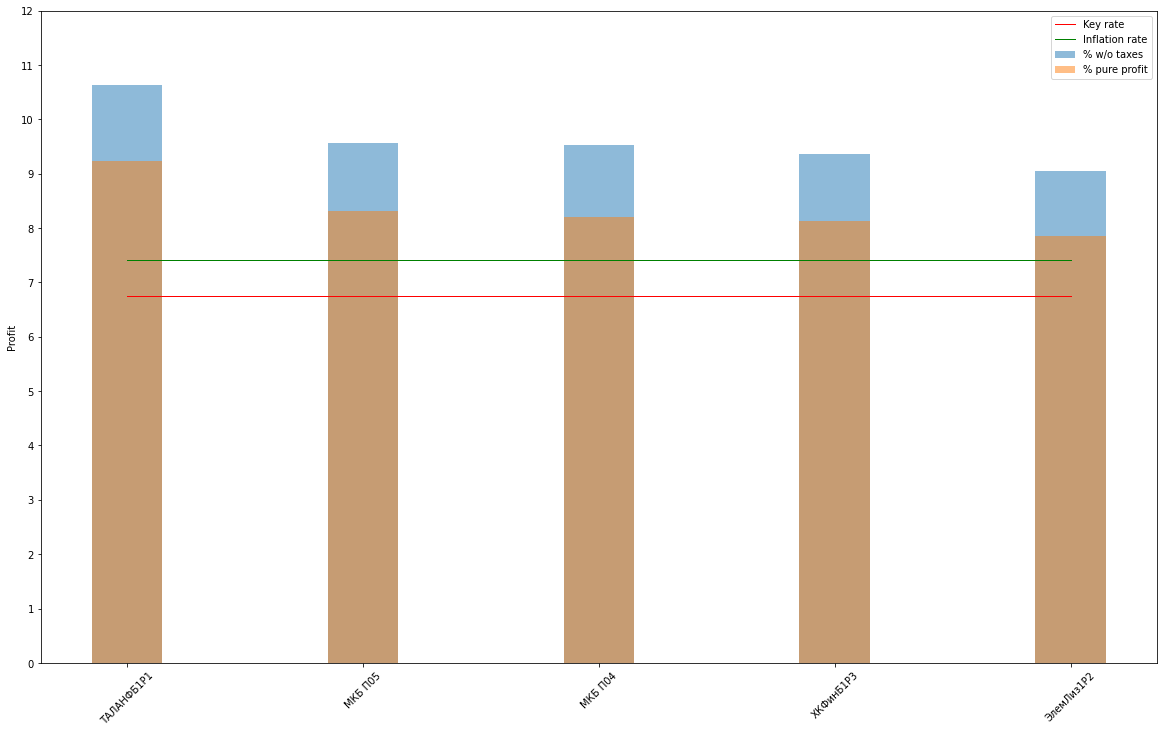

In [131]:
facevalue = final_bonds[['FACEVALUE']].sum().values[0]
price = final_bonds[['PRICE_RUB']].sum().values[0]
income = final_bonds[['COUPON_INCOME']].sum().values[0]
accrued_coupon_interest = final_bonds[['ACCRUED_COUPON_INTEREST']].sum().values[0]
fig, ax = plt.subplots(figsize=(20,12))
ax.bar(final_bonds.SHORTNAME.values, 
       height=final_bonds.reset_index().PROFIT_WITHOUT_TAXES.values, 
       width=0.3, 
       label='% w/o taxes', 
       alpha=0.5)

ax.bar(final_bonds.SHORTNAME.values, 
       height=final_bonds.reset_index().PROFIT.values, 
       width=0.3, 
       label='% pure profit', 
       alpha=0.5)

ax.plot([KEY_RATE] * len(final_bonds), 
        color='r', 
        linewidth=1, 
        label='Key rate')

ax.plot([INFLATION_RATE] * len(final_bonds), 
        color='g', 
        linewidth=1, 
        label='Inflation rate')

ax.set_xticks(range(0, 5))
ax.set_yticks(range(0, 13))
ax.set_ylabel("Profit")
ax.legend()
plt.xticks(rotation=45)
plt.show()

In [138]:
df

,SECID,SHORTNAME,TYPENAME,FACEUNIT,FACEVALUE,PRICE_RUB,IS_QUALIFIED_INVESTORS,HIGH_RISK,DAYSTOREDEMPTION,COUPONDATE,...,COUPONLENGTH,COUPONFREQUENCY,COUPONVALUE,MATDATE,NUMBER_COUPON,COUPON_INCOME,ACCRUED_COUPON_INTEREST,TAXES,PROFIT_WITHOUT_TAXES,PROFIT
900,RU000A100AA4,ТАЛАНФБ1P1,Биржевые облигации,RUB,500.0,510.22,0,0,180.0,2022-01-20,...,91.0,4.0,18.70,2022-04-21,2,37.40,0.410989,3.5334,10.630300,9.227144
1067,RU000A100WT8,МКБ П05,Биржевые облигации,RUB,1000.0,944.14,0,0,352.0,2022-10-10,...,365.0,1.0,32.50,2022-10-10,1,32.50,1.157534,11.4868,9.565561,8.305531
1025,RU000A100SF5,МКБ П04,Биржевые облигации,RUB,1000.0,951.59,0,0,315.0,2022-03-09,...,365.0,1.0,35.00,2022-03-09,1,35.00,4.794521,10.8433,9.524843,8.211098
906,RU000A100AP2,ХКФинБ1P3,Биржевые облигации,RUB,1000.0,1003.00,0,0,180.0,2022-01-20,...,91.0,4.0,24.93,2022-04-21,2,49.86,0.547912,6.0918,9.357861,8.126947
896,RU000A100A41,ЭлемЛиз1P2,Биржевые облигации,RUB,276.0,277.52,0,0,178.0,2022-01-18,...,91.0,4.0,7.05,2022-04-19,2,14.10,0.309890,1.6354,9.056124,7.849094
437,RU000A0JXQ93,ПИК БО-П02,Биржевые облигации,RUB,200.0,202.34,0,0,181.0,2022-01-21,...,91.0,4.0,5.61,2022-04-22,2,11.22,0.061648,1.1544,8.785928,7.635773
1660,RU000A1029P7,ТелХолПБО4,Биржевые облигации,RUB,1000.0,992.05,0,0,363.0,2022-01-21,...,91.0,4.0,19.70,2022-10-21,4,78.80,0.216484,11.2775,8.768843,7.626041
1085,RU000A100YG1,Самолет1P7,Биржевые облигации,RUB,1000.0,1031.84,0,0,361.0,2022-01-19,...,91.0,4.0,29.92,2022-10-19,4,119.68,0.986374,11.4192,8.502493,7.384616
1089,RU000A100YR8,iРОСНАН2P3,Биржевые облигации,RUB,1000.0,993.44,0,0,362.0,2022-04-21,...,182.0,2.0,38.39,2022-10-20,2,76.78,0.421868,10.8342,8.412165,7.313020
1323,RU000A101LQ5,ТМК 1P01,Биржевые облигации,RUB,1000.0,1000.32,0,0,180.0,2022-04-21,...,182.0,2.0,41.64,2022-04-21,1,41.64,0.457582,5.3716,8.279552,7.191157
